# Analyze progeny viral barcodes
This Python Jupyter notebook processes viral barcodes from inside cells (Hoffman-primed vRNA) or supernatants (Hoffman-primed vRNA).

In [2]:
# Parameters
samples_csv = 'data/illumina_runs_viralbc.csv'
expected_flu_seqs = {
    'fluHA': 'GCGGCCGCCTATGGTGCATCATTATATGCAAAT',
    'fluNA': 'GCGGCCGCCTATGGTGCACTATTATTTATCTAT'
}

## Import Python modules
We use [plotnine](https://plotnine.readthedocs.io/) for ggplot2-style plotting:

In [3]:
import os
import subprocess

import numpy
import gzip

import pandas as pd

from plotnine import *
import seaborn as sns

from Bio import SeqIO

from IPython.display import display, HTML
import mizani

Color-blind palette:

In [4]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [5]:
_ = theme_set(theme_classic)

## Read the viral barcode files

In [6]:
print(f"Reading sample list from from {samples_csv}")
samples_df = pd.read_csv(samples_csv, index_col=False, comment="#")

Reading sample list from from data/illumina_runs_viralbc.csv


In [7]:
samples_df

,sample,seqrun,source_type,segment,index_name,index_sequence,FASTQ
0,WT_0d15,2020-08-25,cell,fluHA,NextFlex_66,TGGCTTCA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
1,WT_0d5,2020-08-24,cell,fluHA,NextFlex_65,TGGAACAA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
2,dblSyn_0d15,2020-08-26,cell,fluHA,NextFlex_67,TGGTGGTA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
3,dblSyn_0d5,2020-08-27,cell,fluHA,NextFlex_68,TTCACGCA,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
4,WT_0d15,2020-08-28,supernatant,fluHA,NextFlex_70,AAGAGATC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
5,WT_0d5,2020-08-29,supernatant,fluHA,NextFlex_71,AAGGACAC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
6,dblSyn_0d15,2020-08-30,supernatant,fluHA,NextFlex_72,AATCCGTC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
7,dblSyn_0d5,2020-08-31,supernatant,fluHA,NextFlex_74,ACACGACC,results/temp_viralbc_fastqs/Unid_2_S3_L001_R1_...
8,WT_0d15,2020-09-01,passage,fluHA,NextFlex_75,ACAGATTC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...
9,WT_0d5,2020-09-03,passage,fluHA,NextFlex_77,AGCACCTC,/shared/ngs/illumina/bloom_lab/200824_M04866_0...


#### Trim adapters
Trim adapters using a command line call to cutadapt.
Since this is a time-intensive step, I will skip it if the file already exists.  If I want to replace the file, I will need to manually delete the output file.

In [8]:
adapter_seq = 'AGATCGGAAGAGCACACGTCTGAACTCCAGTCACN{8}ATCTCGTATGCCGTCTTCTGCTTG'

trimmed_fastq_files = []

for sample in samples_df.iterrows():
    raw_file = sample[1]["FASTQ"]
    output_file = 'results/temp_viralbc_fastqs/' + 'trimmed_' + sample[1]["FASTQ"].split('/')[-1]
    print(f'Trimming adapters for sample {sample[1]["sample"]} {sample[1]["source_type"]}.')
    cmd = [
        'cutadapt',
        '-O', '13',
        '-a', adapter_seq+'X',
        '-o', output_file,
        raw_file
          ]
    #print(' '.join(cmd))
    if os.path.exists(output_file):
        print('Trimmed file exists.')
    else:
        subprocess.check_call(cmd)
        print('Done.')
    trimmed_fastq_files.append(output_file)

samples_df['trimmed_FASTQ'] = trimmed_fastq_files

Trimming adapters for sample WT_0d15 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d5 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d15 supernatant.
Trimmed file exists.
Trimming adapters for sample WT_0d5 supernatant.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 supernatant.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 supernatant.
Trimmed file exists.
Trimming adapters for sample WT_0d15 passage.
Trimmed file exists.
Trimming adapters for sample WT_0d5 passage.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 passage.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d5 passage.
Trimmed file exists.
Trimming adapters for sample WT_0d15 cell.
Trimmed file exists.
Trimming adapters for sample WT_0d5 cell.
Trimmed file exists.
Trimming adapters for sample dblSyn_0d15 cell.


#### Load reads from FASTQs

Straight forward loading of raw read sequences into a dataframe.
I annotate metadata (sample, source_type, etc...) simultaneously. However, it may be useful to make this a join call from the samples_df that is already created above.

In [9]:
#abc = samples_df.query('"WT_0d15" in sample and segment == "fluHA"')

reads_list = []

for sample in samples_df.iterrows():
    fastq_file = sample[1]["trimmed_FASTQ"]
    print(f'Loading reads for sample {sample[1]["sample"]} {sample[1]["segment"]} from {fastq_file}\n')
    with gzip.open(fastq_file, "rt") as fastq_file_open:
        reads = SeqIO.parse(fastq_file_open, format='fastq')
        for record in reads:
            reads_list.append({
                'sample': sample[1]["sample"],
                'source_type': sample[1]["source_type"],
                'segment': sample[1]["segment"],
                'read_name': record.name,
                'sequence': str(record.seq),
                #'phred': record.letter_annotations["phred_quality"],
            })

reads_df = pd.DataFrame(reads_list)
reads_df['source_type'] = pd.Categorical(reads_df['source_type'],
                                        categories=['cell','supernatant','passage'],
                                        ordered=True)
#reads_df

Loading reads for sample WT_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-WT-05_S2_L001_R1_001.fastq.gz

Loading reads for sample WT_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-WT-015_S1_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-dblSyn-015_S3_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-cells-dblSyn-05_S4_L001_R1_001.fastq.gz

Loading reads for sample WT_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-WT-015_S5_L001_R1_001.fastq.gz

Loading reads for sample WT_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-WT-05_S6_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d15 fluHA from results/temp_viralbc_fastqs/trimmed_HA-supernatant-dblSyn-015_S7_L001_R1_001.fastq.gz

Loading reads for sample dblSyn_0d5 fluHA from results/temp_viralbc_fastqs/trimmed_Unid_2_S3_L001_R1_001.fastq.gz

Lo

## Parse the viral barcode and segment identity
Next, I extract the viral barcode from the first 16 bp of the sequence.

The following 33 bp (the shorter of the two lengths) should match either the fluHA or fluNA sequence exactly. The expected sequences are defined at the top of this notebook in the `expected_flu_seqs` dictionary.

If the sequence does not match the expected flu sequence exactly, the read is marked `False` for in the `match` column, and is not included in downstream analysis.

In [10]:
reads_df['viral_bc'] = reads_df['sequence'].str.slice(0,16)
#reads_df['viral_bc_qual'] = numpy.mean(reads_df['phred'].str.slice(0,16))
reads_df['flu_seq'] = reads_df['sequence'].str.slice(16,49)
reads_df['expected_flu_seq'] = reads_df['segment'].map(expected_flu_seqs)
reads_df['match'] = reads_df['flu_seq'] == reads_df['expected_flu_seq']

In [11]:
reads_df

,sample,source_type,segment,read_name,sequence,viral_bc,flu_seq,expected_flu_seq,match
0,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:9593:2108,ATTTTCGCTTTCAGTACTATGTTCTTTTCCGTTATTGCTTAGCGGC...,ATTTTCGCTTTCAGTA,CTATGTTCTTTTCCGTTATTGCTTAGCGGCCGC,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,False
1,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:13411:2141,AAGGAATCTATTTGGCGCGGCCGCCTATGGTGCATCATTATATGCA...,AAGGAATCTATTTGGC,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
2,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:21601:2144,CGGCCCCCTCGGAAGAGCGGCCGCCTATGGTGCATCATTATATGCA...,CGGCCCCCTCGGAAGA,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
3,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:12127:2152,CTGATTTGAAGTAATAGCGGCCGCCTATGGTGCATCATTATATGCA...,CTGATTTGAAGTAATA,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,True
4,WT_0d15,cell,fluHA,M04866:401:000000000-J84HR:1:1101:9603:2157,ATTTTCGCTTTCAGTACTATGTTCTTTTCCGTTATTGCTTAGCGGC...,ATTTTCGCTTTCAGTA,CTATGTTCTTTTCCGTTATTGCTTAGCGGCCGC,GCGGCCGCCTATGGTGCATCATTATATGCAAAT,False
...,...,...,...,...,...,...,...,...,...
26524234,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:13088:25289,CAATACAAATATAACAGCGGCCGCCTATGGTGCACNNNNNNNTATC...,CAATACAAATATAACA,GCGGCCGCCTATGGTGCACNNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False
26524235,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:20396:25290,ACAACCTCGATTGCTAGCGGCCGCCTATGGTGCACNANNNNTTATC...,ACAACCTCGATTGCTA,GCGGCCGCCTATGGTGCACNANNNNTTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False
26524236,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:18079:25292,CAATACAAATATAACAGCGGCCGCCTATGGTGCACNNNNNNNTATC...,CAATACAAATATAACA,GCGGCCGCCTATGGTGCACNNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False
26524237,dblSyn_0d5,passage,fluNA,M04866:401:000000000-J84HR:1:2119:14885:25292,CTATACAAATATAACAGCGGCCGCCTATGGTGCACNNNNNNNTATC...,CTATACAAATATAACA,GCGGCCGCCTATGGTGCACNNNNNNNTATCTAT,GCGGCCGCCTATGGTGCACTATTATTTATCTAT,False


## Sequencing QC
#### Read Counts
Plot the raw number of reads kept for each sample.

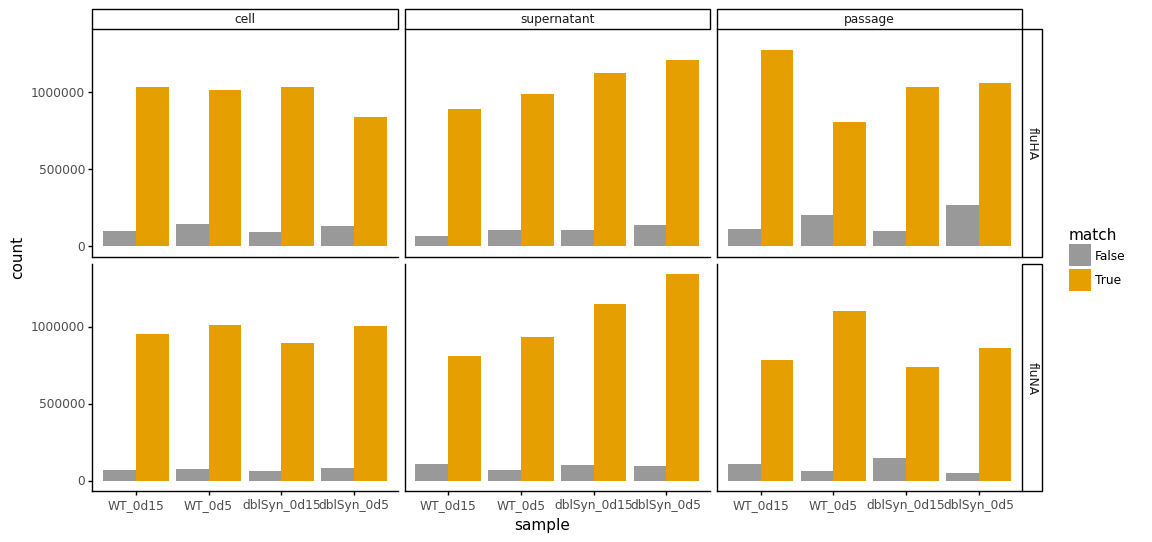

In [11]:
p = (ggplot(reads_df, aes(x='sample', fill='match')) +
     geom_bar(position='dodge') +
     facet_grid('segment~source_type') +
     theme(figure_size=(12, 6)) +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

#### Number of Unique Barcodes
Plot the number of unique barcodes for each sample. I'm not sure exactly how many I expect here.

In [27]:
n_unique_df = pd.DataFrame(reads_df.groupby(['sample','source_type','segment'])['viral_bc'].nunique())
n_unique_df = n_unique_df.reset_index()
n_unique_df = n_unique_df.rename(columns={'viral_bc':'n_viral_bc'})

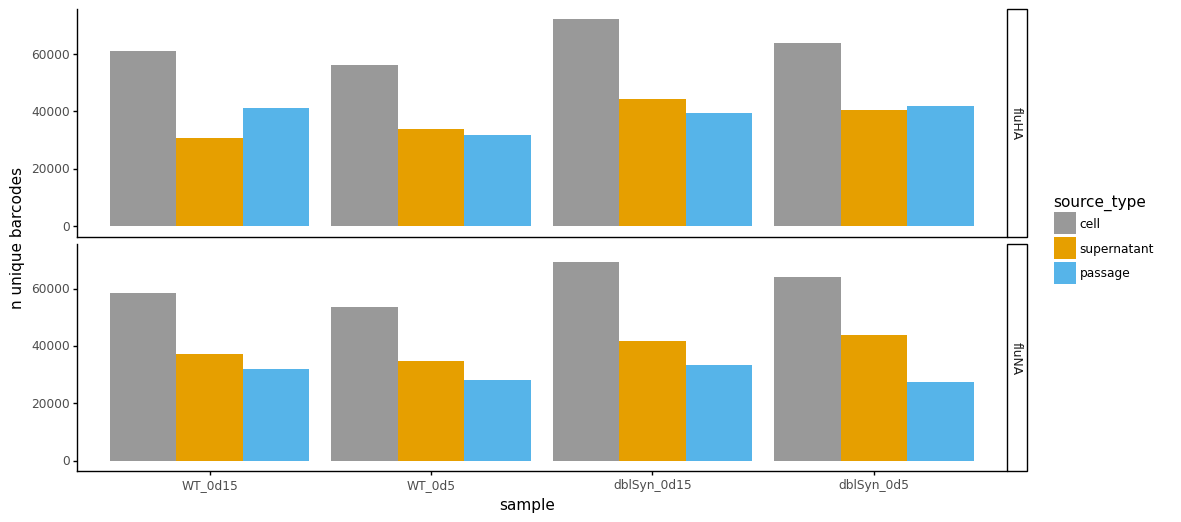

In [28]:
p = (ggplot(n_unique_df, aes(x='sample', y='n_viral_bc', fill='source_type')) +
     geom_bar(stat='identity',position='dodge') +
     facet_grid('segment~') +
     theme(figure_size=(12, 6)) +
     ylab('n unique barcodes') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

## Count viral barcodes
For each sample, count the frequency of each observed barcode.

I also include an variable here, `threshold`, which is used to filter out all barcodes below a certain number of raw reads. For now, I have set this threshold to zero to look at the data in its complete form.

In [27]:
barcode_counts_df = pd.DataFrame(reads_df.groupby(['sample','source_type','segment'])['viral_bc'].value_counts())
barcode_counts_df = barcode_counts_df.rename(columns={'viral_bc':'n_reads'})
barcode_counts_df = barcode_counts_df.reset_index(level=['viral_bc','sample','source_type','segment'])

#### Calculate read fractions
Since each sample has a different number of reads,  will calculate the fraction of reads assigned to each barcode within its sequencing sample.

In [28]:
total_read_counts_df = reads_df.groupby(['sample','source_type','segment']) \
                                        .count().reset_index().iloc[:,0:4] \
                                        .rename(columns={'read_name':'total_reads'})

barcode_counts_df = barcode_counts_df.merge(total_read_counts_df, on = ['sample','source_type','segment'], how = 'left')

barcode_counts_df['frac_reads'] = barcode_counts_df['n_reads'] / barcode_counts_df['total_reads']

In [29]:
barcode_counts_df

,sample,source_type,segment,viral_bc,n_reads,total_reads,frac_reads
0,WT_0d15,cell,fluHA,CTCTGCGTAAGTTGCA,12171,1132979,0.010742
1,WT_0d15,cell,fluHA,CTATCATAGCAGAATG,5887,1132979,0.005196
2,WT_0d15,cell,fluHA,ATAAGTATTTGTCAGT,5198,1132979,0.004588
3,WT_0d15,cell,fluHA,TGATCTCCGTTGTAAT,4900,1132979,0.004325
4,WT_0d15,cell,fluHA,GTATGTTCGAGCAGGC,4623,1132979,0.004080
...,...,...,...,...,...,...,...
1079794,dblSyn_0d5,passage,fluNA,TTTTTTACCTTTAGAC,1,913904,0.000001
1079795,dblSyn_0d5,passage,fluNA,TTTTTTACTCGATCAA,1,913904,0.000001
1079796,dblSyn_0d5,passage,fluNA,TTTTTTCGGCCCTCGG,1,913904,0.000001
1079797,dblSyn_0d5,passage,fluNA,TTTTTTTAATACCTAC,1,913904,0.000001


#### Test threshold for considering a viral bc "real" 
There are more viral barcodes identified than should be present in the innoculum, and barcode sharing between samples from the same infection is poor. I will test whether many barcodes present at low frequency are introducing noise into the assay, likely from PCR errors.

In [30]:
def filter_viral_bc(viral_bc, n_reads, threshold):
    #print(viral_bc, n_reads, threshold)
    status = False
    if n_reads < threshold:
        status = True
    if 'N' in viral_bc:
        status = True
    return status

In [74]:
test_threshold_df = barcode_counts_df.copy(deep=True)

for t in [0,10,50,100,1000]:

    test_threshold = t #cutoff for including a barcode

    test_threshold_df[f'filtered_{t}'] = test_threshold_df.apply(lambda x: filter_viral_bc(
                                                                       x['viral_bc'],
                                                                        x['n_reads'],
                                                                        test_threshold), axis=1)

In [79]:
test_threshold_df=pd.melt(test_threshold_df, id_vars = ['sample','source_type','segment'], value_vars=[f'filtered_{t}' for t in [0,10,50,100,1000]])

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.


KeyError: "The following 'value_vars' are not present in the DataFrame: ['filtered_0', 'filtered_10', 'filtered_100', 'filtered_1000', 'filtered_50']"

In [80]:
test_threshold_df['variable'] = pd.Categorical(test_threshold_df['variable'],
                                              categories=['filtered_0','filtered_10','filtered_50','filtered_100','filtered_1000'],
                                              ordered=True)

In [ ]:
p = (ggplot(test_threshold_df, aes(x='variable', fill='value')) +
     geom_bar(stat='count',position='dodge') +
     theme(figure_size=(12, 6)) +
     ylab('n barcodes') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

In [31]:
threshold = 0 #cutoff for including a barcode

barcode_counts_df['filtered'] = barcode_counts_df.apply(lambda x: filter_viral_bc(
                                                                       x['viral_bc'],
                                                                        x['n_reads'],
                                                                        threshold), axis=1)

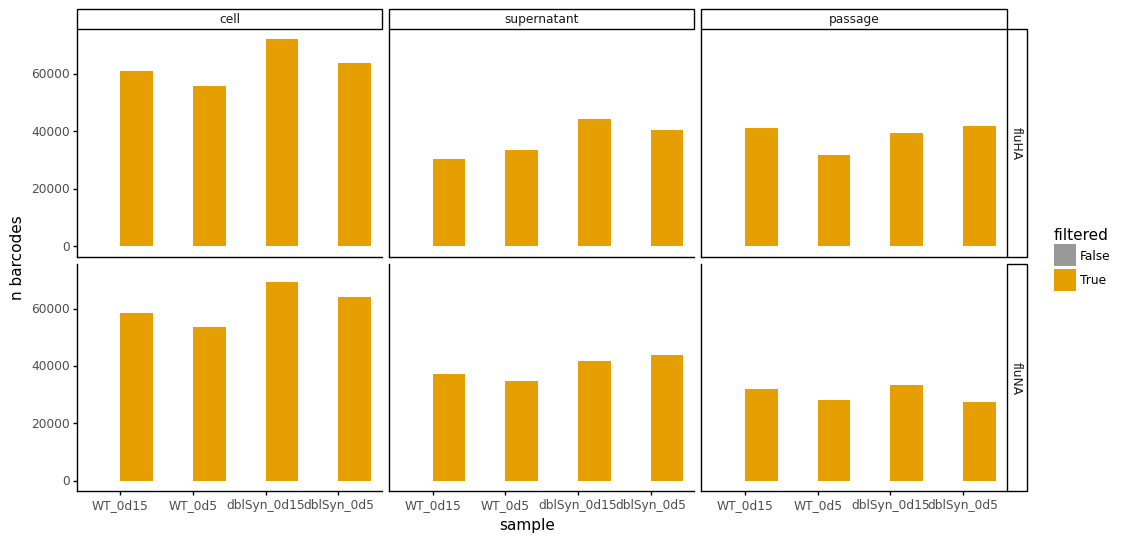

In [69]:
p = (ggplot(barcode_counts_df, aes(x='sample', fill='filtered')) +
     geom_bar(stat='count',position='dodge') +
     facet_grid('segment~source_type') +
     theme(figure_size=(12, 6)) +
     ylab('n barcodes') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

#### Distribution of viral barcodes
Plot the distribution of viral barcodes for each sample.

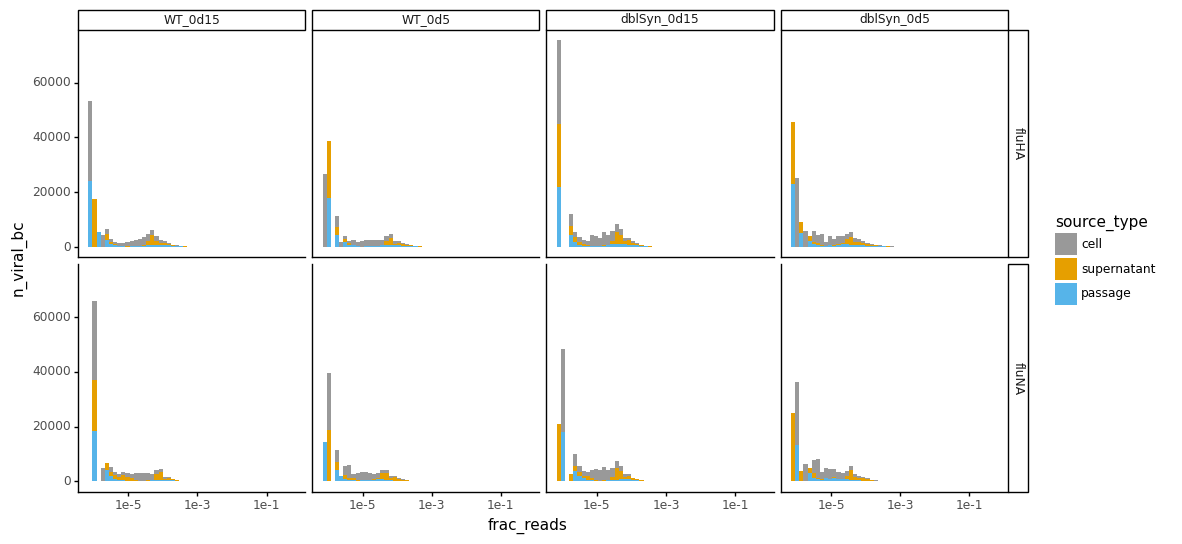

In [32]:
p = (ggplot(barcode_counts_df.query('not filtered'), aes(x='frac_reads', fill='source_type')) +
     geom_histogram(bins=50) +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10() +
     ylab('n_viral_bc') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

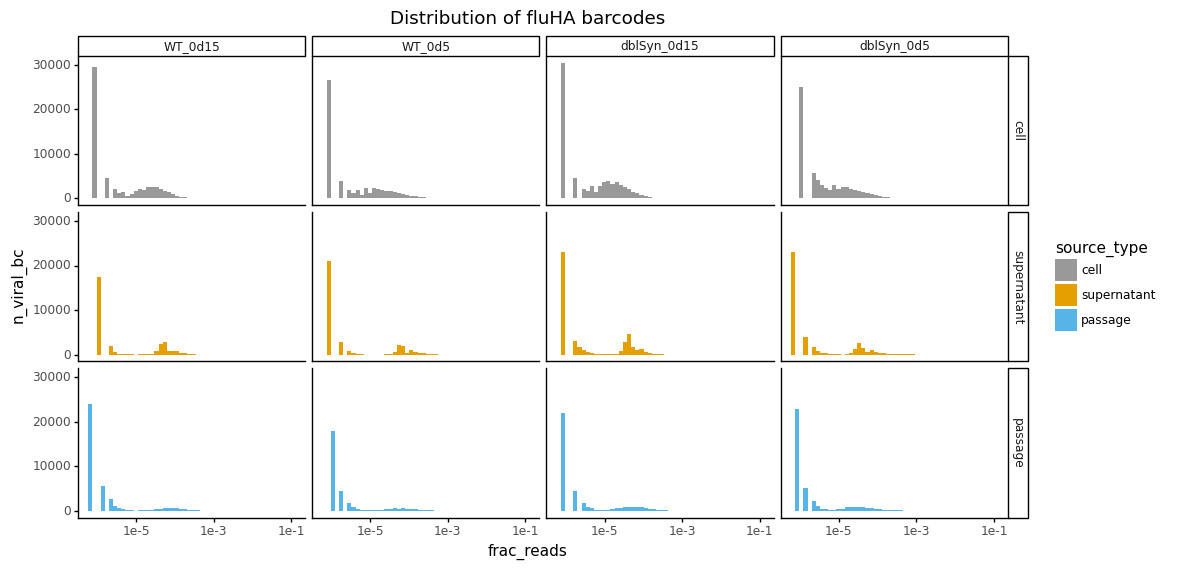

In [33]:
p = (ggplot(barcode_counts_df.query('not filtered and segment=="fluHA"'), aes(x='frac_reads', fill='source_type')) +
     geom_histogram(bins=50) +
     facet_grid('source_type~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10() +
     ggtitle('Distribution of fluHA barcodes') +
     ylab('n_viral_bc') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

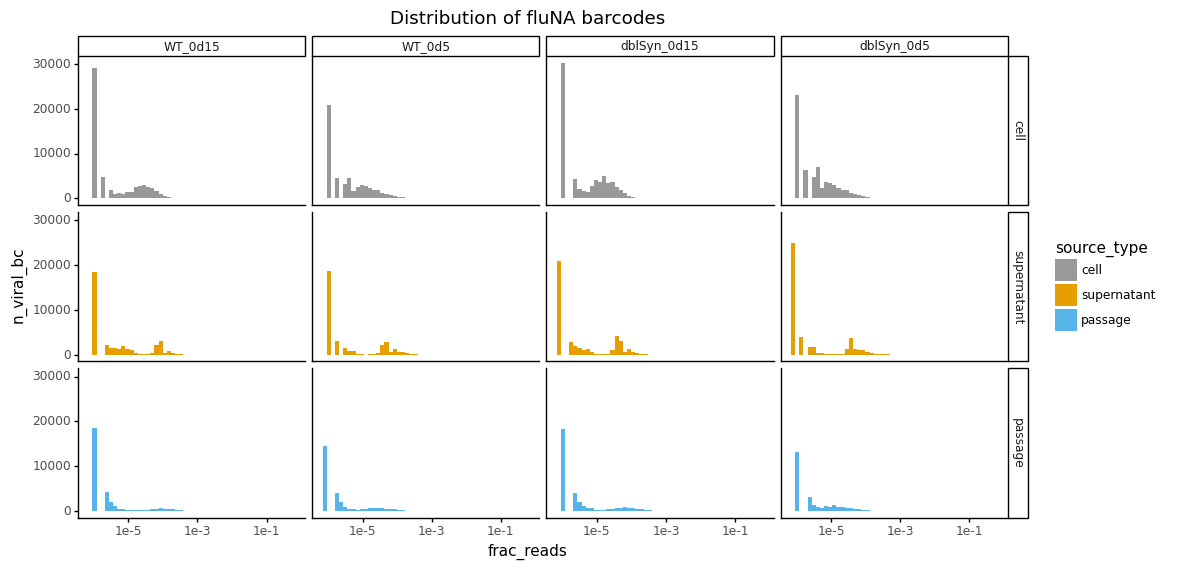

In [35]:
p = (ggplot(barcode_counts_df.query('not filtered and segment=="fluNA"'), aes(x='frac_reads', fill='source_type')) +
     geom_histogram(bins=50) +
     facet_grid('source_type~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10() +
     ggtitle('Distribution of fluNA barcodes') +
     ylab('n_viral_bc') +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

#### Make wide dataframe
Here, I take the barcode count data from `barcode_counts_df` and pivot the table to wide format. This gives a dataframe, `barcode_counts_wide`, where every row is a unique barcode (for a given sample and segment), and there is one column for the number of reads found in the cell, one column for the number of reads found in the supernatant, and one column for the number of reads found in the passaged sample.

In [69]:
barcode_counts_wide = pd.pivot_table(barcode_counts_df.query('not filtered'), index=['sample','segment','viral_bc'], columns=['source_type'], values=['frac_reads'])
barcode_counts_wide = barcode_counts_wide.fillna(0)
barcode_counts_wide = barcode_counts_wide.rename(columns=str).reset_index()
barcode_counts_wide.columns = ['_'.join(tup) for tup in barcode_counts_wide.columns.values]
barcode_counts_wide = barcode_counts_wide.rename(columns={'viral_bc_': 'viral_bc', 'sample_': 'sample', 'segment_': 'segment'})

In [70]:
barcode_counts_wide

,sample,segment,viral_bc,frac_reads_cell,frac_reads_supernatant,frac_reads_passage
0,WT_0d15,fluHA,AAAAAAAAAAATTCAA,8.826289e-07,0.000000e+00,0.000000e+00
1,WT_0d15,fluHA,AAAAAAAAATTCAAAG,2.647887e-06,0.000000e+00,7.230104e-07
2,WT_0d15,fluHA,AAAAAAAACCCTCGGT,0.000000e+00,0.000000e+00,7.230104e-07
3,WT_0d15,fluHA,AAAAAAAATACAGATT,0.000000e+00,1.039624e-06,0.000000e+00
4,WT_0d15,fluHA,AAAAAAAATTCAAAGT,1.765258e-05,0.000000e+00,7.230104e-07
...,...,...,...,...,...,...
798776,dblSyn_0d5,fluNA,TTTTTTTTCTCTTTAC,2.757477e-06,0.000000e+00,9.847861e-06
798777,dblSyn_0d5,fluNA,TTTTTTTTCTTTACCC,5.514954e-06,0.000000e+00,2.188414e-06
798778,dblSyn_0d5,fluNA,TTTTTTTTTACCTCTA,0.000000e+00,0.000000e+00,1.094207e-06
798779,dblSyn_0d5,fluNA,TTTTTTTTTATTGGAA,2.757477e-06,0.000000e+00,0.000000e+00


#### Parse barcodes present at each step in experiment
Naiively, I would expect each real barcode found in the supernatant to be derived from the set of barcodes found in the cell. Likewise, I would expect each real barcode found in the passaged sample to be found in the set of barcodes from the supernatant.

Here I mark whether a barcode is found in the cell, supernatant, and/or passage. Then, to make a simplified, interpretable, 2-group Venn Diagram, I use a simple function to mark whether each barcode is found in Either/Or/Both the cell and supernatant. I do the same to mark whether each barcode is found in Either/Or/Both the supernatant and passage sample.

These are then plotted. Neither indicates that a barcode was not found in either of the relevant source_types, but it must necessarily exist in the third source_type for that sample.

In [71]:
residence_df = barcode_counts_wide.copy(deep=True)
residence_df['in_cell'] = residence_df['frac_reads_cell'] > threshold
residence_df['in_supernatant'] = residence_df['frac_reads_supernatant'] > threshold
residence_df['in_passage'] = residence_df['frac_reads_passage'] > threshold

def parse_residence(source1, source2, source1_value, source2_value):
    if source1_value == True and source2_value == False:
        return source1
    elif source1_value == False and source2_value == True:
        return source2
    elif source1_value == True and source2_value == True:
        return 'both'
    elif source1_value == False and source2_value == False:
        return 'neither'

residence_df['cell_and_supernatant'] = residence_df.apply(lambda x: parse_residence(
                                                                    'cell', 'supernatant',
                                                                    x['in_cell'], x['in_supernatant']), axis=1)
residence_df['cell_and_supernatant'] = pd.Categorical(residence_df['cell_and_supernatant'],
                                                      categories=['neither','supernatant','both','cell'],
                                                      ordered=True)

residence_df['supernatant_and_passage'] = residence_df.apply(lambda x: parse_residence(
                                                                    'supernatant', 'passage',
                                                                    x['in_supernatant'], x['in_passage']), axis=1)
residence_df['supernatant_and_passage'] = pd.Categorical(residence_df['supernatant_and_passage'],
                                                      categories=['neither','passage','both','supernatant'],
                                                      ordered=True)

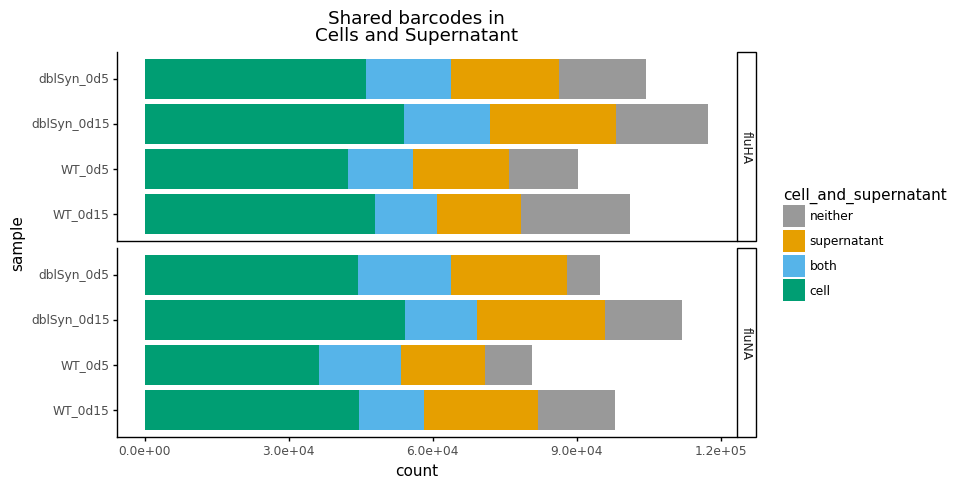

In [72]:
p = (ggplot(residence_df, aes(x='sample', fill='cell_and_supernatant')) +
     geom_bar(stat="count") +
     coord_flip() +
     facet_grid('segment~') +
     theme(figure_size=(8, 5)) +
     ggtitle('Shared barcodes in\nCells and Supernatant') +
     scale_y_continuous(labels=mizani.formatters.scientific_format()) +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

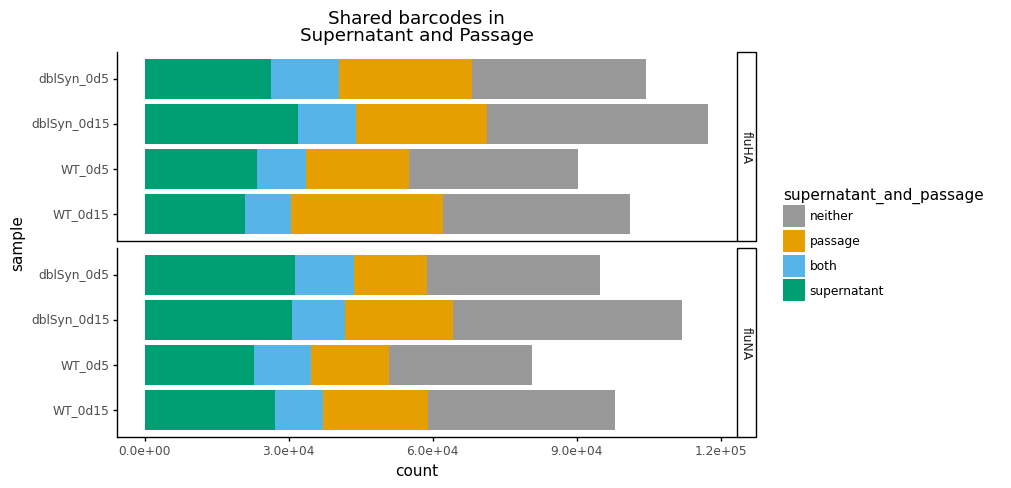

In [73]:
p = (ggplot(residence_df, aes(x='sample', fill='supernatant_and_passage')) +
     geom_bar(stat='count') +
     coord_flip() +
     facet_grid('segment~') +
     theme(figure_size=(8, 5)) +
     ggtitle('Shared barcodes in\nSupernatant and Passage') +
     scale_y_continuous(labels=mizani.formatters.scientific_format()) +
     scale_fill_manual(cbpalette[0:])
     )
_ = p.draw()

## Correlation of viral barcodes
- Plot the correlation between viral barcode counts in the cell and in the supernatant.
- Plot the correlation between viral barcode counts in the supernatant and in the passage sample.
- Plot the correlation between viral barcode counts in the cell and in the passage sample.

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


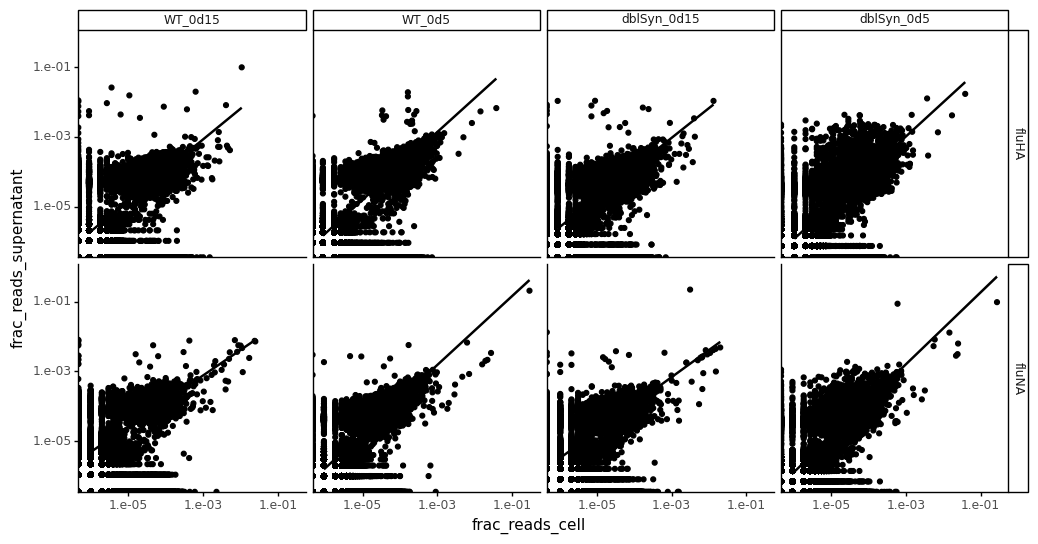

In [74]:
p = (ggplot(barcode_counts_wide.fillna({'frac_reads_cell':0,'v_supernatant':0}),
                    aes(x='frac_reads_cell', y='frac_reads_supernatant')) +
     geom_point() +
     geom_smooth(method='lm') +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10(labels=mizani.formatters.scientific_format()) +
     scale_y_log10(labels=mizani.formatters.scientific_format())
     )
_ = p.draw()

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


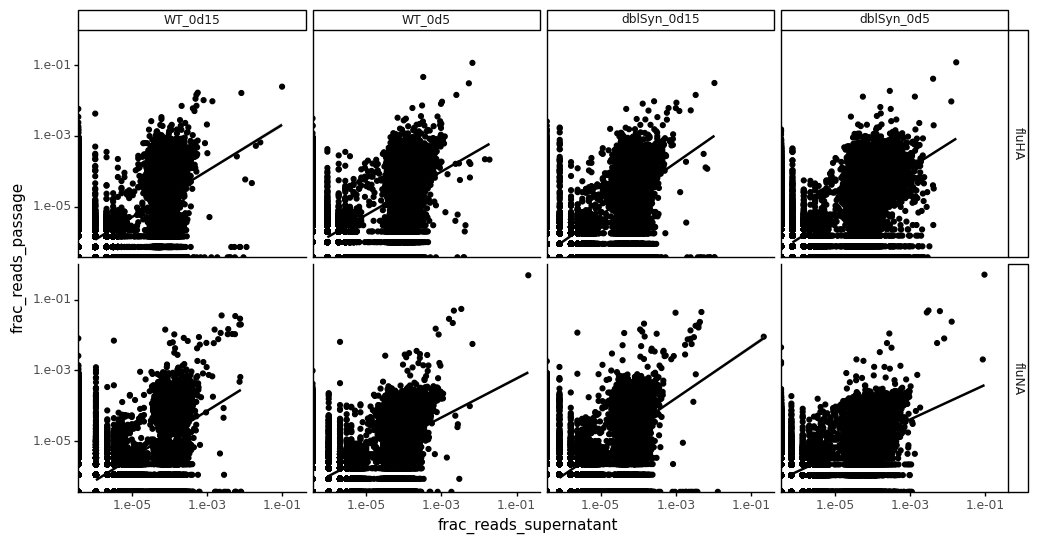

In [75]:
p = (ggplot(barcode_counts_wide.fillna({'frac_reads_supernatant':0,'frac_reads_passage':0}),
                    aes(x='frac_reads_supernatant', y='frac_reads_passage')) +
     geom_point() +
    geom_smooth(method='lm') +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10(labels=mizani.formatters.scientific_format()) +
     scale_y_log10(labels=mizani.formatters.scientific_format())
     )
_ = p.draw()

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


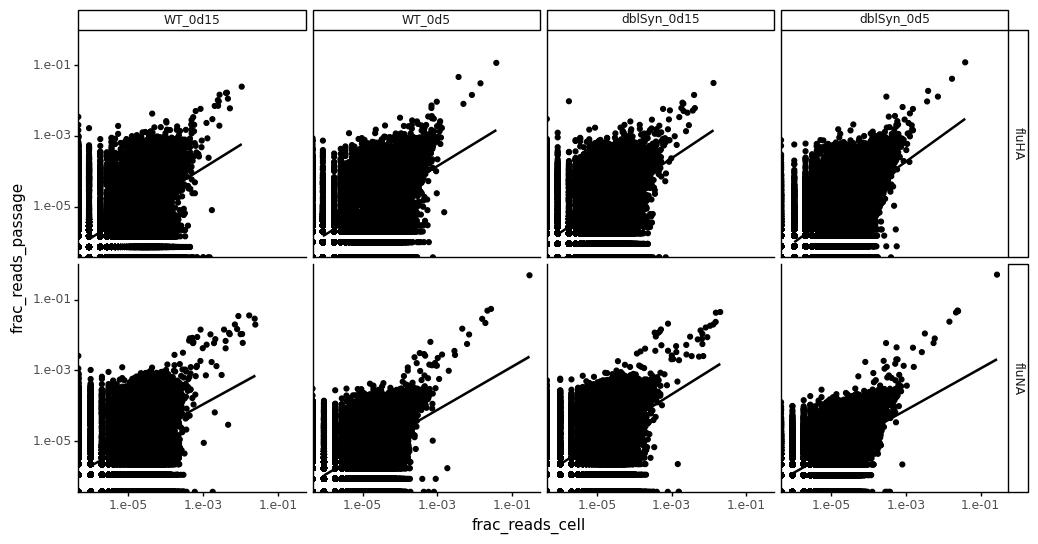

In [76]:
p = (ggplot(barcode_counts_wide.fillna({'frac_reads_cell':0,'frac_reads_passage':0}),
                    aes(x='frac_reads_cell', y='frac_reads_passage')) +
     geom_point() +
     geom_smooth(method='lm') +
     facet_grid('segment~sample') +
     theme(figure_size=(12, 6)) +
     scale_x_log10(labels=mizani.formatters.scientific_format()) +
     scale_y_log10(labels=mizani.formatters.scientific_format())
     )
_ = p.draw()

In [77]:
barcode_counts_wide.groupby(['sample','segment']).corr().reset_index()

,sample,segment,level_2,frac_reads_cell,frac_reads_supernatant,frac_reads_passage
0,WT_0d15,fluHA,frac_reads_cell,1.000000,0.590289,0.798974
1,WT_0d15,fluHA,frac_reads_supernatant,0.590289,1.000000,0.525749
2,WT_0d15,fluHA,frac_reads_passage,0.798974,0.525749,1.000000
3,WT_0d15,fluNA,frac_reads_cell,1.000000,0.550425,0.810181
4,WT_0d15,fluNA,frac_reads_supernatant,0.550425,1.000000,0.512391
5,WT_0d15,fluNA,frac_reads_passage,0.810181,0.512391,1.000000
6,WT_0d5,fluHA,frac_reads_cell,1.000000,0.341687,0.927834
7,WT_0d5,fluHA,frac_reads_supernatant,0.341687,1.000000,0.264190
8,WT_0d5,fluHA,frac_reads_passage,0.927834,0.264190,1.000000
9,WT_0d5,fluNA,frac_reads_cell,1.000000,0.990577,0.998820


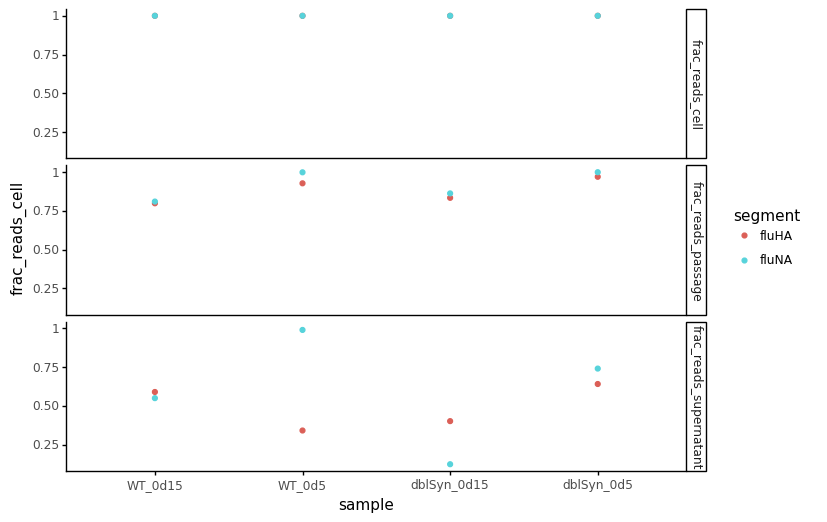

In [78]:
p = (ggplot(barcode_counts_wide.groupby(['sample','segment']).corr().reset_index(),
                    aes(x='sample', y='frac_reads_cell', color='segment')) +
     geom_point() +
     facet_grid('level_2~') +
     theme(figure_size=(8, 6))
     )
_ = p.draw()

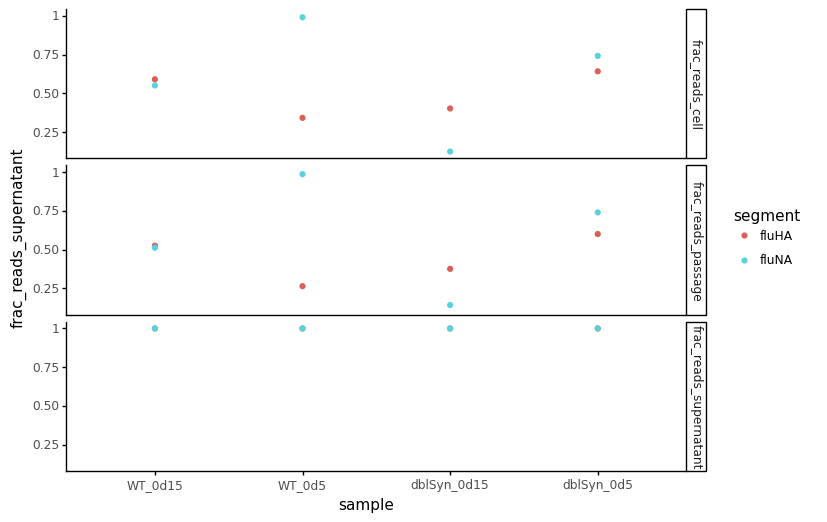

In [79]:
p = (ggplot(barcode_counts_wide.groupby(['sample','segment']).corr().reset_index(),
                    aes(x='sample', y='frac_reads_supernatant', color='segment')) +
     geom_point() +
     facet_grid('level_2~') +
     theme(figure_size=(8, 6))
     )
_ = p.draw()

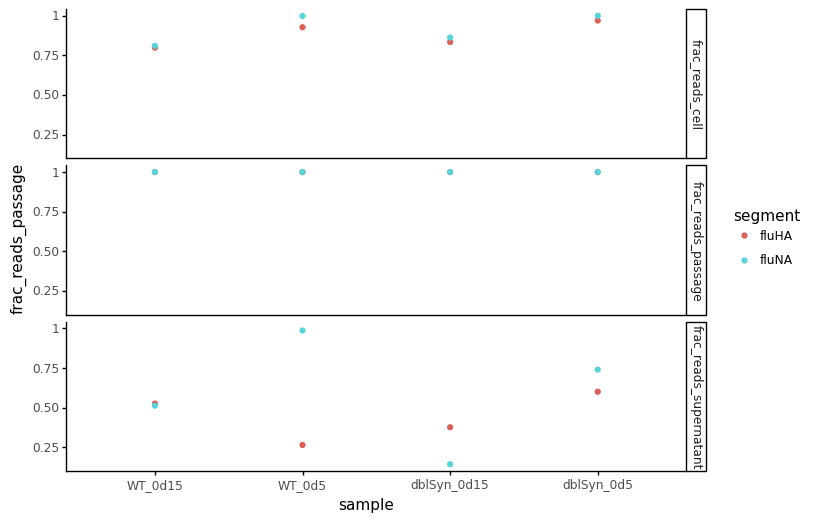

In [80]:
p = (ggplot(barcode_counts_wide.groupby(['sample','segment']).corr().reset_index(),
                    aes(x='sample', y='frac_reads_passage', color='segment')) +
     geom_point() +
     facet_grid('level_2~') +
     theme(figure_size=(8, 6))
     )
_ = p.draw()